## Necessary imports

In [1]:
from neuralyzer.datasets import FlatPatchDataset
from neuralyzer.datasets import load_image
import torch

## Constants

In [2]:
n_concepts = 16
patch_size = 5
stride = 1
learning_rate = 0.05
batch_size = 16
init_low = 0
init_high = 1
n_iterations = 1000000
image_file = "/Users/arnaudabreu/Downloads/lenna.png"

In [3]:
concepts = torch.nn.Linear(in_features=patch_size * patch_size, out_features=n_concepts, bias=False)
# initialize the weights of the concepts with random values between init_low and init_high (0 and 1 here to match input value range)
torch.nn.init.uniform_(concepts.weight, init_low, init_high)

Parameter containing:
tensor([[0.3869, 0.7560, 0.6177, 0.1885, 0.2761, 0.6145, 0.8801, 0.0926, 0.1857,
         0.1678, 0.6414, 0.7209, 0.7495, 0.3533, 0.0663, 0.5566, 0.2771, 0.5051,
         0.8819, 0.0363, 0.7628, 0.8863, 0.0260, 0.4424, 0.6382],
        [0.2325, 0.3291, 0.5204, 0.2431, 0.9987, 0.3678, 0.9188, 0.7244, 0.8313,
         0.4888, 0.1981, 0.7835, 0.4094, 0.5722, 0.6269, 0.9869, 0.4680, 0.8710,
         0.2404, 0.1360, 0.8211, 0.1689, 0.4868, 0.8810, 0.1062],
        [0.3707, 0.4337, 0.4099, 0.6326, 0.0820, 0.7881, 0.0191, 0.1457, 0.6261,
         0.1760, 0.0816, 0.3638, 0.3037, 0.0270, 0.8786, 0.8292, 0.4031, 0.7882,
         0.0791, 0.5029, 0.2624, 0.4637, 0.9721, 0.1564, 0.6519],
        [0.4568, 0.3544, 0.4273, 0.6069, 0.5262, 0.5744, 0.0483, 0.6934, 0.4306,
         0.3625, 0.9534, 0.0520, 0.4041, 0.5692, 0.7968, 0.4334, 0.6981, 0.8591,
         0.8439, 0.4288, 0.5478, 0.3869, 0.1931, 0.7720, 0.5403],
        [0.0136, 0.1441, 0.0685, 0.9998, 0.2370, 0.8944, 0.2620, 0

## Data Loader

In [4]:
dataset = FlatPatchDataset(patch_size=patch_size, stride=stride, batch_size=batch_size)

## WTA implementation as temperature softmax

In [5]:
def temperature_softmax(
    logits: torch.Tensor,
    temperature: float = 1.0
):
    """
    Apply a softmax function to the logits with a temperature.
    
    Args:
        logits (torch.Tensor): the input logits
        temperature (float): the temperature to apply to the logits
        
    Returns:
        torch.Tensor: the output of the softmax function
    """
    return torch.nn.functional.softmax(logits/temperature, dim=1)

def winners_take_all(logits):
    """
    Apply the winners-take-all function to the logits.
    
    Args:
        logits (torch.Tensor): the input logits
        
    Returns:
        torch.Tensor: the output of the winners-take-all function (0 for all values except the maximum)
    """
    logit_max = logits.max(dim=1, keepdim=True).values
    wta = torch.where(logits < logit_max, torch.zeros_like(logits), logits)
    return wta

## Update rule

In [6]:
def oja_update_rule(
    weights: torch.Tensor,
    x: torch.Tensor,
    y: torch.Tensor,
    learning_rate: float
):
    """
    Compute new weights using the Oja update rule.
    
    Args:
        weights (torch.Tensor): The weights of the model with shape (out_features, in_features).
        x (torch.Tensor): The input data with shape (batch, in_features).
        y (torch.Tensor): The output data with shape (batch, out_features).
        learning_rate (float): The learning rate.
    """
    # add a feature dimension to x (to match the weights dimensions)
    inputs = x.unsqueeze(1) # (batch, 1, in_features)
    # add a feature dimension to y (to match the weights dimensions)
    outputs = y.unsqueeze(-1) # (batch, out_features, 1)
    # add a batch dimension to the weights (to match the inputs dimensions)
    synapses = weights.unsqueeze(0) # (1, out_features, in_features)
    # logits to probabilities
    z = temperature_softmax(y) # (batch, out_features)
    # set non-maximum values to zero in z (anti-Hebbian plasticity)
    winners = winners_take_all(z) # (batch, out_features)
    # add a feature dimension to z (to match the weights dimensions)
    winners = winners.unsqueeze(-1) # (batch, out_features, 1)
    # apply the Oja update rule
    # synaptic activity. Synapses will learn if the output is active
    synaptic_activity = synapses * outputs # (batch, out_features, in_features)
    # hebbian error. Active neurons will strengthen the affinity between the inputs and their synaptic weights
    error = inputs - synaptic_activity # (batch, out_features, in_features)
    delta = learning_rate * winners * error # (batch, out_features, in_features)
    updates = synapses + delta # (batch, out_features, in_features
    # average the updates over the batch
    updated_synapses = updates.mean(dim=0) # (out_features, in_features)
    return updated_synapses

## Training loop

In [7]:
loader = dataset.load(
    img_path=image_file,
    gray=True
)
for idx, batch in enumerate(loader):
    if idx > n_iterations:
        break
    x = batch["image"]
    y = concepts(x)
    if idx == 0:
        print(f"Shape of a batch of x: {x.shape}")
        print(f"Shape of a batch of y: {y.shape}")
        print(f"Batch number {idx}")
        print(f"First Input: {x[0]}")
        print(f"First Output: {y[0]}")
    # update the weights
    with torch.no_grad():
        w_updated = oja_update_rule(concepts.weight, x, y, learning_rate)
        concepts.weight.data = w_updated

Shape of a batch of x: torch.Size([16, 25])
Shape of a batch of y: torch.Size([16, 16])
Batch number 0
First Input: tensor([0.1401, 0.1208, 0.1441, 0.1351, 0.1446, 0.1540, 0.1268, 0.1559, 0.1685,
        0.2150, 0.1436, 0.1472, 0.1870, 0.2220, 0.2337, 0.1659, 0.1592, 0.2168,
        0.2426, 0.2474, 0.1782, 0.2085, 0.2339, 0.2653, 0.2773])
First Output: tensor([2.1103, 2.4273, 1.9932, 2.4705, 1.7627, 1.7545, 2.3822, 1.9713, 1.8015,
        2.2892, 2.1427, 1.9679, 2.0583, 2.1606, 1.9581, 1.9537],
       grad_fn=<SelectBackward0>)


In [8]:
# input tensor (x) shape: (batch, in_features)
# weight tensor (concepts.weight) shape: (out_features, in_features)
# output tensor shape: (batch, out_features)

# "repeat" way of doing things
# repeated_weights = einops.repeat(concepts.weight, 'o i -> b o i', b=32)
# test_repeated = repeated_weights * y.unsqueeze(-1)
# "unsqueeze" way of doing things
# test_unsqueezed = concepts.weight.unsqueeze(0) * y.unsqueeze(-1)

# check that the test_repeated and test_unsqueezed are the same
# print(torch.allclose(test_repeated, test_unsqueezed))
# display the shapes of the repeated weights
# print(repeated_weights.shape)


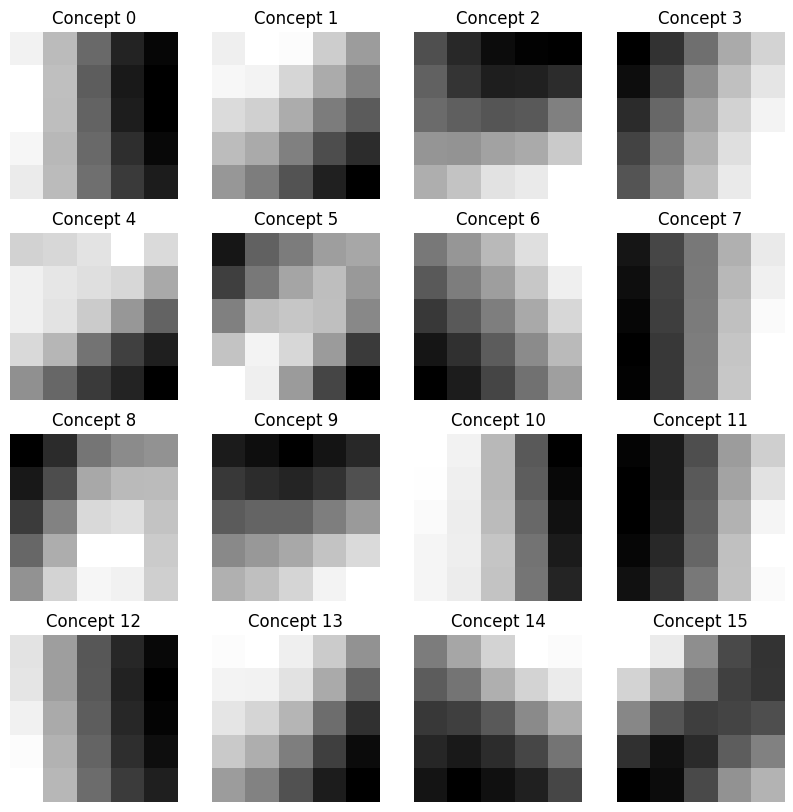

In [9]:
# plot concepts
import matplotlib.pyplot as plt
import numpy as np

n_size = int(np.sqrt(n_concepts))

fig, axs = plt.subplots(n_size, n_size, figsize=(10, 10))
for i in range(n_concepts):
    ax = axs[i//n_size, i%n_size]
    ax.imshow(
        concepts.weight[i].detach().numpy().reshape(patch_size, patch_size),
        cmap="gray"
    )
    ax.axis("off")
    ax.set_title(f"Concept {i}")

In [10]:
# let's create a conv2d layer with the learned concepts
conv = torch.nn.Conv2d(
    in_channels=1,
    out_channels=n_concepts,
    kernel_size=patch_size,
    stride=1,
    padding=0,
    bias=False
)
# check shape of conv
print(f"Shape of convolution weights: {conv.weight.shape}")
# check the shape of the concepts
print(f"Shape of concepts weights: {concepts.weight.shape}")


Shape of convolution weights: torch.Size([16, 1, 5, 5])
Shape of concepts weights: torch.Size([16, 25])


In [11]:
kernels_ = concepts.weight.reshape(n_concepts, 1, patch_size, patch_size)
# compute mirrored kernels
kernels_ = torch.flip(kernels_, dims=[2, 3])
conv.weight.data = kernels_
    

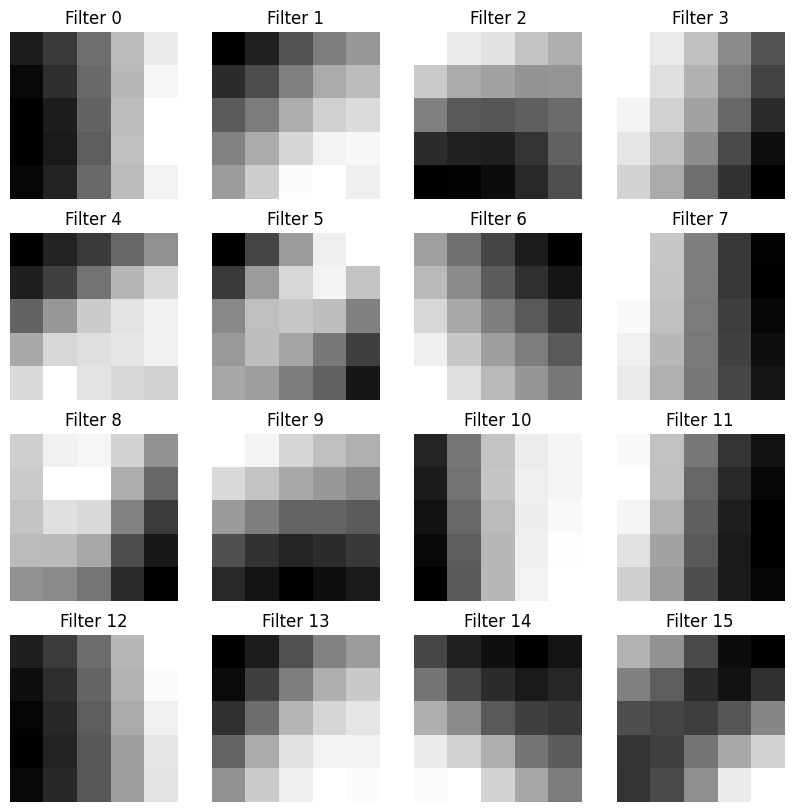

In [12]:
# plot the filters of the convolution to check visually that the copying worked
fig, axs = plt.subplots(n_size, n_size, figsize=(10, 10))
for i in range(n_concepts):
    ax = axs[i//n_size, i%n_size]
    ax.imshow(
        conv.weight[i].detach().numpy().reshape(patch_size, patch_size),
        cmap="gray"
    )
    ax.axis("off")
    ax.set_title(f"Filter {i}")

Output shape: torch.Size([1, 16, 508, 508])


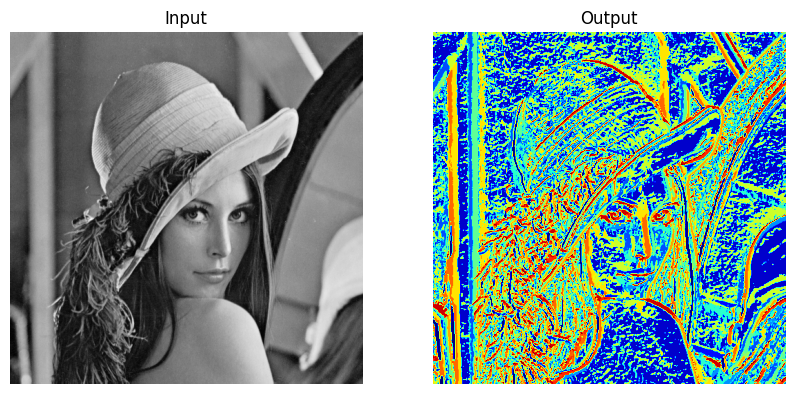

In [13]:
# load an image
image = load_image(image_file, gray=True)
# put the image in a tensor
image_ = torch.tensor(image).unsqueeze(0).unsqueeze(0).float()
# apply the convolution
output_ = conv(image_)
print(f"Output shape: {output_.shape}")
# apply the softmax to the output
probas_ = temperature_softmax(output_)
# apply argmax to get the most activated concept
concept_map_ = torch.argmax(probas_, dim=1)
# plot the input and output
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(image, cmap="gray")
axs[0].axis("off")
axs[0].set_title("Input")
axs[1].imshow(concept_map_.squeeze().detach().numpy(), cmap="jet")
axs[1].axis("off")
axs[1].set_title("Output")
plt.show()

Concept probabilities shape: torch.Size([1, 508, 508])


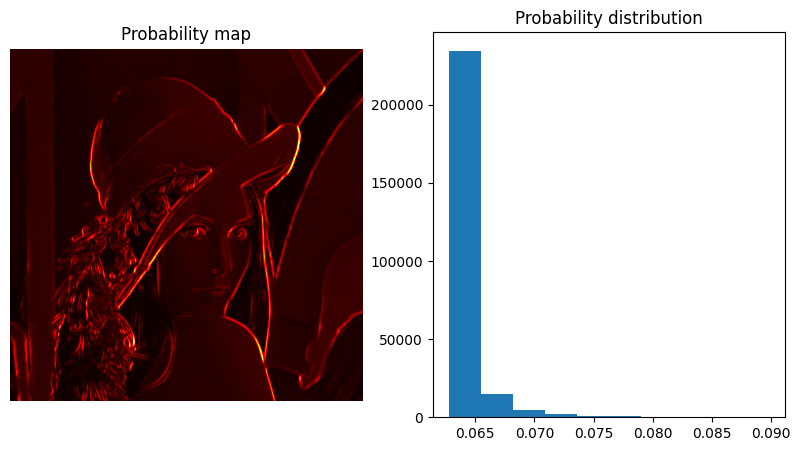

In [14]:
# check the probability of the output
concept_probas_ = torch.max(probas_, dim=1).values
print(f"Concept probabilities shape: {concept_probas_.shape}")
# plot the probability map and the distribution of the probabilities
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(concept_probas_.squeeze().detach().numpy(), cmap="hot")
axs[0].axis("off")
axs[0].set_title("Probability map")
axs[1].hist(concept_probas_.squeeze().detach().numpy().flatten())
axs[1].set_title("Probability distribution")
plt.show()

In [15]:
probas = probas_.squeeze().detach().numpy()
probas.shape

(16, 508, 508)

In [1]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(probas[1], cmap="hot")
axs[0].axis("off")
axs[0].set_title("Probability map")
axs[1].hist(probas[0].flatten())
axs[1].set_title("Probability distribution")
plt.show()

NameError: name 'plt' is not defined